In [53]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import networkx as nx
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore", category=DeprecationWarning)
    
plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 28
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate synthetic networks with speficied parameters

In [73]:
!g++ -O3 -std=c++17  ../src/generatingSD_unix.cpp -o generateSD

In [94]:
# Dimension = 1
# Beta = 2
# Number of nodes = 1000
# Exponent of the power-law distribution for the hidden degrees = 2.5
# Mean degree = 10

!./generateSD -d 1 -b 2 -n 1000 -g 2.5 -k 10 -o example_net -v

OUTPUT_ROOTNAME = /home/rob/repo/SD-model/notebooks/example_net
edgelist_file = /home/rob/repo/SD-model/notebooks/example_net.edge


In [95]:
g = nx.read_edgelist("example_net.edge")
print(g)

Graph with 994 nodes and 5649 edges


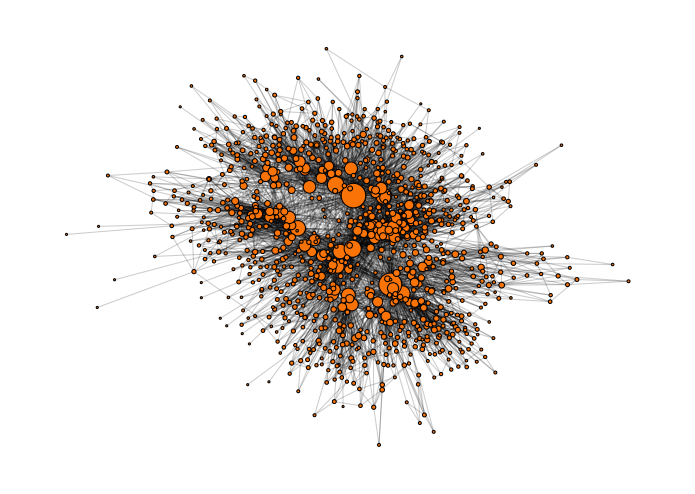

In [96]:
pos = nx.spring_layout(g)
node_size_list = [2 * (d + 1) for d in dict(g.degree).values()]

nx.draw_networkx_edges(g, pos=pos, alpha=0.2)
nx.draw_networkx_nodes(g, node_size=node_size_list, pos=pos,
                       edgecolors='black', linewidths=1, node_color='xkcd:orange')
plt.axis('off')
plt.show()

In [97]:
coords = pd.read_csv("example_net.gen_coord", sep="\s+")
coords.columns = ['vertex', 'kappa', 'radius', 'theta', 'real_deg', 'exp_deg', 'tmp']
coords.drop('tmp', axis=1, inplace=True)
coords.head()

,vertex,kappa,radius,theta,real_deg,exp_deg
0,v0,4.07667,14.6488,1.259400,6,3.98568
1,v1,12.25840,12.4469,0.464479,9,11.36920
2,v2,36.63150,10.2575,3.485630,41,39.02260
3,v3,4.36959,14.5100,5.409460,10,6.89449
4,v4,4.72867,14.3521,5.838530,7,7.51817


100%|██████████████████████████████████████████████████████████████████████████| 5649/5649 [00:06<00:00, 861.52it/s]


(0.0, 14.8407)

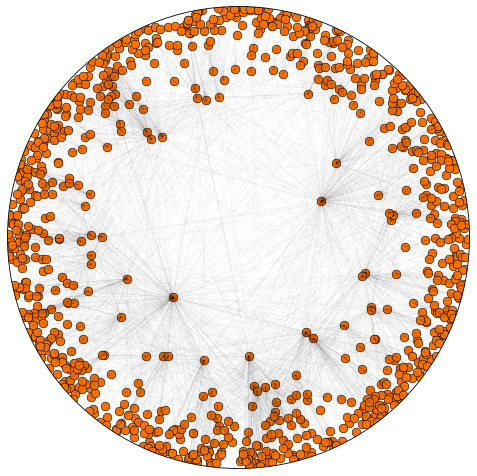

In [98]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

for source, target in tqdm(g.edges()):
    s = coords[coords['vertex'] == source]
    t = coords[coords['vertex'] == target]    
    ax.plot([s['theta'], t['theta']], [s['radius'], t['radius']], 
            color='black', alpha=0.2, linewidth=0.1)

ax.scatter(coords['theta'], coords['radius'], s=70, color='xkcd:orange', edgecolors='black',
           alpha=1, linewidths=0.5)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(coords['radius']))

Text(0, 0.5, '$P_C(k)$')

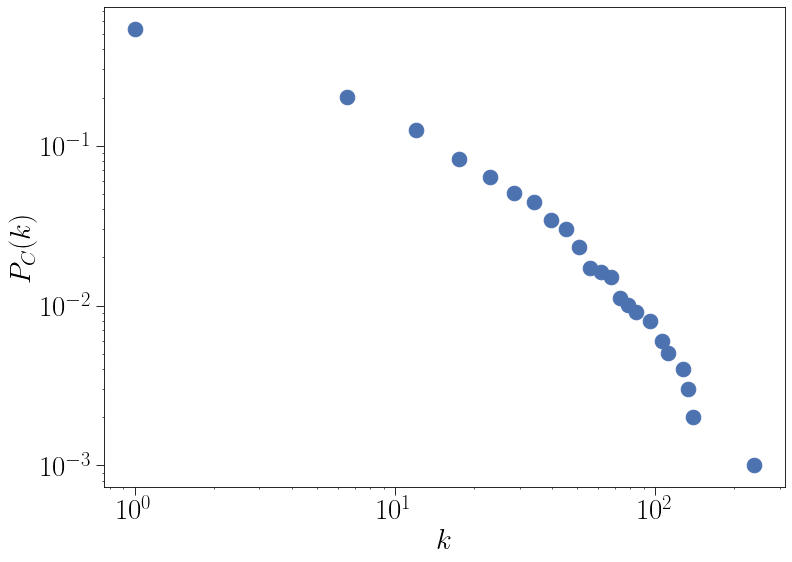

In [102]:
prob, bins = np.histogram(list(dict(g.degree).values()), bins=50, density=True)

non_zeros = np.where(prob != 0)
prob, bins = prob[non_zeros], bins[non_zeros]

plt.scatter(bins[:-1], 1 - (prob / prob.sum()).cumsum()[:-1])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$k$')
plt.ylabel('$P_C(k)$')

In [104]:
nx.average_clustering(g), nx.average_shortest_path_length(g)

(0.49451426439009727, 2.896606223443379)

---
---

# Infer a set of hidden degrees and parameter from the input network. Based on them generate synthetic networks from the model.


Network of protein-protein interactions in Saccharomyces cerevisiae (budding yeast), measured by co-complex associations identified by high-throughput affinity purification and mass spectrometry (AP/MS)1


_From: https://networks.skewed.de/net/collins_yeast_
    

In [115]:
!g++ -O3 -std=c++17 -lgfortran -I ../include/ ../include/trapecis_Sd.o  ../src/infer_kappas_beta_unix.cpp -o infer_kappas_beta

In [117]:
# When there is more than one component the code will extract the GCC and save the edgelist to _GC file.

!./infer_kappas_beta -d 1 collins_yeast/collings_yeast.edge


More than one component found (1004/1622) vertices in the largest component.
Edges belonging to the largest component saved to collins_yeast/collings_yeast_GC.edge. Please rerun the program using this new edgelist.



In [118]:
!./infer_kappas_beta -d 1 collins_yeast/collings_yeast_GC.edge

Inferred beta = 4.3309


In [143]:
!./generateSD -d 1 -b 4.3309 -l collins_yeast/collings_yeast_GC.kappas -o test -v

OUTPUT_ROOTNAME = /home/rob/repo/SD-model/notebooks/collins_yeast/test
edgelist_file = /home/rob/repo/SD-model/notebooks/collins_yeast/test.edge


In [144]:
g2 = nx.read_edgelist("collins_yeast/test.edge")
print(g2)

Graph with 951 nodes and 8290 edges


In [145]:
coords2 = pd.read_csv("collins_yeast/test.gen_coord", sep="\s+")
coords2.columns = ['vertex', 'kappa', 'radius', 'theta', 'real_deg', 'exp_deg', 'tmp']
coords2.drop('tmp', axis=1, inplace=True)
coords2.head()

,vertex,kappa,radius,theta,real_deg,exp_deg
0,v0,5.99302,39.0855,3.716410,8,9.11151
1,v1,0.99854,42.6696,0.831639,4,3.34030
2,v2,3.99487,39.8966,2.784380,2,4.29143
3,v3,3.99487,39.8966,2.902740,5,5.83608
4,v4,5.99302,39.0855,0.815580,5,4.48597


100%|██████████████████████████████████████████████████████████████████████████| 8290/8290 [00:09<00:00, 906.73it/s]


(0.0, 42.769600000000004)

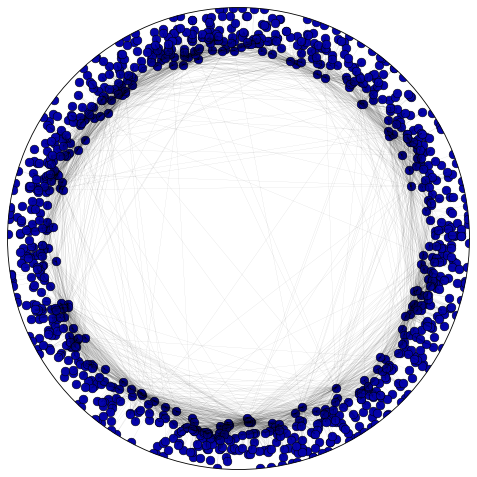

In [154]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

for source, target in tqdm(g2.edges()):
    s = coords2[coords2['vertex'] == source]
    t = coords2[coords2['vertex'] == target]    
    ax.plot([s['theta'], t['theta']], [s['radius'], t['radius']], 
            color='black', alpha=0.35, linewidth=0.1)

ax.scatter(coords2['theta'], coords2['radius'], s=70, color='xkcd:royal blue', edgecolors='black',
           alpha=1, linewidths=0.5)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(coords2['radius'])+0.1)

In [155]:
g3 = nx.read_edgelist("collins_yeast/collings_yeast_GC.edge")
print(g3)

Graph with 1004 nodes and 8319 edges


In [156]:
# Compare the average clustering between the original graph and the synthetic network
nx.average_clustering(g3), nx.average_clustering(g2)

(0.6475137704697581, 0.6570317313018904)

In [157]:
# Compare the mean degree
np.mean(list(dict(g3.degree).values())), np.mean(list(dict(g2.degree).values()))

(16.57171314741036, 17.434279705573083)